# Experimentally obtained structure analysis
* How many genes or mutations with clusters are and are not covered by experimentally obtained structures? 
* Quantify the added value of using AlphaFold predicted structures in the prediction of driver genes and mutations

## Get a dataframe for PDB to Uniprot mapping

* Used canonical Uniprot ID
* Removed structures without resolution info (NMR): to discuss (around 1xx structures)

In [20]:
import pandas as pd
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
import sys

sys.path.append('../../')
from global_variables import SUBDIR, RUN, WORKSPACE

In [22]:
!wget -O pdb_chain_uniprot.tsv.gz "https://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/tsv/pdb_chain_uniprot.tsv.gz"
# !wget -O uniprot_pdb.tsv.gz "https://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/tsv/uniprot_pdb.tsv.gz"
# !wget -O UP000000226_3885.dat.gz "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000000226/UP000000226_3885.dat.gz"
# !wget -O UP000000226_3885.idmapping.gz "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000000226/UP000000226_3885.idmapping.gz"

--2025-04-30 12:15:16--  https://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/tsv/pdb_chain_uniprot.tsv.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5513957 (5.3M) [application/x-gzip]
Saving to: ‘pdb_chain_uniprot.tsv.gz’

pdb_chain_uniprot.t 100%[===================>]   5.26M  12.1MB/s    in 0.4s    

2025-04-30 12:15:17 (12.1 MB/s) - ‘pdb_chain_uniprot.tsv.gz’ saved [5513957/5513957]



In [ ]:
# Load PDB to Uniprot mapping
pdb_uniprot = pd.read_table("pdb_chain_uniprot.tsv.gz", skiprows=1)
display(pdb_uniprot)

pdb_uniprot = pdb_uniprot[pdb_uniprot["CHAIN"] == "A"]
pdb_uniprot = pdb_uniprot[["PDB", "SP_PRIMARY", "SP_BEG", "SP_END"]].rename(
    columns={"SP_PRIMARY" : "Uniprot_ID", "SP_BEG" : "Start", "SP_END": "End"}).reset_index(drop=True)
pdb_uniprot

,PDB,CHAIN,SP_PRIMARY,RES_BEG,RES_END,PDB_BEG,PDB_END,SP_BEG,SP_END
0,101m,A,P02185,1,154,0,153,1,154
1,102l,A,P00720,1,40,1,40,1,40
2,102l,A,P00720,42,165,41,None,41,164
3,102m,A,P02185,1,154,0,153,1,154
4,103l,A,P00720,1,40,1,None,1,40
...,...,...,...,...,...,...,...,...,...
886830,9xia,A,P24300,1,388,1,None,1,388
886831,9xim,A,P12851,1,393,None,394,2,394
886832,9xim,B,P12851,1,393,None,394,2,394
886833,9xim,C,P12851,1,393,None,394,2,394


,PDB,Uniprot_ID,Start,End
0,101m,P02185,1,154
1,102l,P00720,1,40
2,102l,P00720,41,164
3,102m,P02185,1,154
4,103l,P00720,1,40
...,...,...,...,...
218773,9ula,A9A2G5,1,245
218774,9umb,Q9YIJ1,1,724
218775,9wga,P02876,28,198
218776,9xia,P24300,1,388


In [ ]:
# Get genes detected by O3D
canonical_metadata = pd.read_table(f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_240506/seq_for_mut_prob.tsv")
canonical_metadata = canonical_metadata[["Gene", "Uniprot_ID"]].drop_duplicates().reset_index(drop=True)

genetable = pd.read_table(f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/o3d_paper/notebooks/0.genetables/results/{SUBDIR}/{RUN}.genetable.tsv")
genetable = genetable[["Gene", "CGC", "Fish", "o3d_qval"]]
genetable = genetable[genetable["o3d_qval"] < 0.01].reset_index(drop=True)
genetable = genetable[["Gene", "CGC"]].drop_duplicates()
genetable = genetable.merge(canonical_metadata, on="Gene", how="left")
genetable

,Gene,CGC,Uniprot_ID
0,PIK3CA,1,P42336
1,RXRA,0,P19793
2,FGFR3,1,P22607
3,FBXW7,1,Q969H0
4,TP53,1,P04637
...,...,...,...
268,CNBD1,1,Q8NA66
269,CDH1,1,P12830
270,TRIM49C,0,P0CI26
271,SPTA1,0,P02549


In [ ]:
# Get PDB structures with covered regions mapped to genes detected by O3D
pdb_uniprot = genetable.merge(pdb_uniprot, on="Uniprot_ID", how="inner")
pdb_uniprot

,Gene,CGC,Uniprot_ID,PDB,Start,End
0,PIK3CA,1,P42336,2enq,331,481
1,PIK3CA,1,P42336,2rd0,1,1068
2,PIK3CA,1,P42336,3hhm,1,1068
3,PIK3CA,1,P42336,3hiz,1,1068
4,PIK3CA,1,P42336,3zim,107,1046
...,...,...,...,...,...,...
4614,EPAS1,1,Q99814,6x3d,239,348
4615,EPAS1,1,Q99814,7ujv,523,542
4616,EPAS1,1,Q99814,8ck3,239,350
4617,EPAS1,1,Q99814,8ck4,239,350


In [ ]:
# Get resolution of PDB structures

pdb_ids = pdb_uniprot["PDB"].unique()
api_url = "https://data.rcsb.org/rest/v1/core/entry/"

def get_resolution(pdb_id, retries=2):
    for attempt in range(retries + 1): 
        try:
            response = requests.get(api_url + pdb_id, timeout=60)  
            response.raise_for_status()
            data = response.json()
            resolution = data.get("rcsb_entry_info", {}).get("resolution_combined", [None])
            return pdb_id, resolution[0] if resolution else None
        except requests.exceptions.Timeout:
            if attempt < retries:
                print(f"Timeout for {pdb_id}, retrying ({attempt+1}/{retries})...")
                continue
            else:
                print(f"Failed to retrieve {pdb_id} after {retries} retries.")
                return pdb_id, None
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {pdb_id}: {e}")
            return pdb_id, None

resolutions = {}
with ThreadPoolExecutor(max_workers=10) as executor:  
    future_to_pdb = {executor.submit(get_resolution, pdb_id): pdb_id for pdb_id in pdb_ids}

    for future in tqdm(as_completed(future_to_pdb), total=len(pdb_ids), desc="Fetching Resolutions"):
        pdb_id, resolution = future.result()
        resolutions[pdb_id] = resolution

Fetching Resolutions: 100%|██████████| 4447/4447 [03:00<00:00, 24.60it/s]


In [ ]:
# Get resolution and save
pdb_uniprot["Resolution"] = pdb_uniprot.PDB.map(resolutions)
pdb_uniprot.to_csv("pdb_uniprot_o3d_predicted_drivers.tsv", sep="\t", index=False, compression="gzip")
pdb_uniprot

,Gene,CGC,Uniprot_ID,PDB,Start,End,Resolution
0,PIK3CA,1,P42336,2enq,331,481,NaN
1,PIK3CA,1,P42336,2rd0,1,1068,3.050
2,PIK3CA,1,P42336,3hhm,1,1068,2.800
3,PIK3CA,1,P42336,3hiz,1,1068,3.300
4,PIK3CA,1,P42336,3zim,107,1046,2.850
...,...,...,...,...,...,...,...
4614,EPAS1,1,Q99814,6x3d,239,348,2.000
4615,EPAS1,1,Q99814,7ujv,523,542,1.800
4616,EPAS1,1,Q99814,8ck3,239,350,1.707
4617,EPAS1,1,Q99814,8ck4,239,350,2.290


## How many genes detected have a solved structure?
### Unique genes

__Resolution:__
* <1.5 Å → Excellent, near atomic-level precision.
* 1.5–2.5 Å → Good, sufficient for reliable side-chain modeling.
* 2.5–3.5 Å → Moderate, backbone is reliable, but some side chains may be ambiguous.
* \>3.5 Å → Low.

In [ ]:
def report_genes_in_pdb(pdb_uniprot, genetable):
        
    genes_in_pdb = pdb_uniprot[["Gene", "CGC", "Uniprot_ID"]].drop_duplicates()
    print(f"Total: {len(genes_in_pdb)} on {len(genetable)} ({len(genes_in_pdb) / len(genetable) * 100:.2f}%)")
    for cgc in [1, 0]:
        genetable_cgc = genetable[genetable["CGC"] == cgc]
        genes_in_pdb_cgc = genes_in_pdb[genes_in_pdb['CGC'] == cgc]
        print(f"CGC {cgc}: {len(genes_in_pdb_cgc)} on {len(genetable_cgc)} ({len(genes_in_pdb_cgc) / len(genetable_cgc) * 100:.2f}%)")
        
        
        
print("Detected genes in solved structures:\n")
print("> Any quality:")
report_genes_in_pdb(pdb_uniprot, genetable)

print("\n> Å < 3.5:")
report_genes_in_pdb(pdb_uniprot[pdb_uniprot["Resolution"] < 3.5], genetable)

print("\n> Å < 2.5:")
report_genes_in_pdb(pdb_uniprot[pdb_uniprot["Resolution"] < 2.5], genetable)

print("\n> Å < 1.5:")
report_genes_in_pdb(pdb_uniprot[pdb_uniprot["Resolution"] < 1.5], genetable)

Detected genes in solved structures:

> Any quality:
Total: 144 on 273 (52.75%)
CGC 1: 92 on 106 (86.79%)
CGC 0: 52 on 167 (31.14%)

> Å < 3.5:
Total: 133 on 273 (48.72%)
CGC 1: 87 on 106 (82.08%)
CGC 0: 46 on 167 (27.54%)

> Å < 2.5:
Total: 110 on 273 (40.29%)
CGC 1: 75 on 106 (70.75%)
CGC 0: 35 on 167 (20.96%)

> Å < 1.5:
Total: 30 on 273 (10.99%)
CGC 1: 25 on 106 (23.58%)
CGC 0: 5 on 167 (2.99%)


In [ ]:
# Define the total number of genes in each category
total_genes = 273
cgc1_total = 106
cgc0_total = 167

# Define the detected genes at different PDB quality thresholds
in_pdb_genes = {
    "Any Quality": {"All": 144, "CGC": 92, "Not CGC": 52},
    "Å < 3.5": {"All": 133, "CGC": 87, "Not CGC": 46},
    "Å < 2.5": {"All": 110, "CGC": 75, "Not CGC": 35},
    "Å < 1.5": {"All": 30, "CGC": 25, "Not CGC": 5},
}

# Compute not detected genes
not_pdb_genes = {
    quality: {
        "All": total_genes - values["All"],
        "CGC": cgc1_total - values["CGC"],
        "Not CGC": cgc0_total - values["Not CGC"],
    }
    for quality, values in in_pdb_genes.items()
}

# Convert to DataFrame for easier handling
df_in_pdb = pd.DataFrame(in_pdb_genes).T
df_not_in_pdb = pd.DataFrame(not_pdb_genes).T

display(df_in_pdb)
display(df_not_in_pdb)


,All,CGC,Not CGC
Any Quality,144,92,52
Å < 3.5,133,87,46
Å < 2.5,110,75,35
Å < 1.5,30,25,5


,All,CGC,Not CGC
Any Quality,129,14,115
Å < 3.5,140,19,121
Å < 2.5,163,31,132
Å < 1.5,243,81,162


NameError: name 'df_in_pdb' is not defined

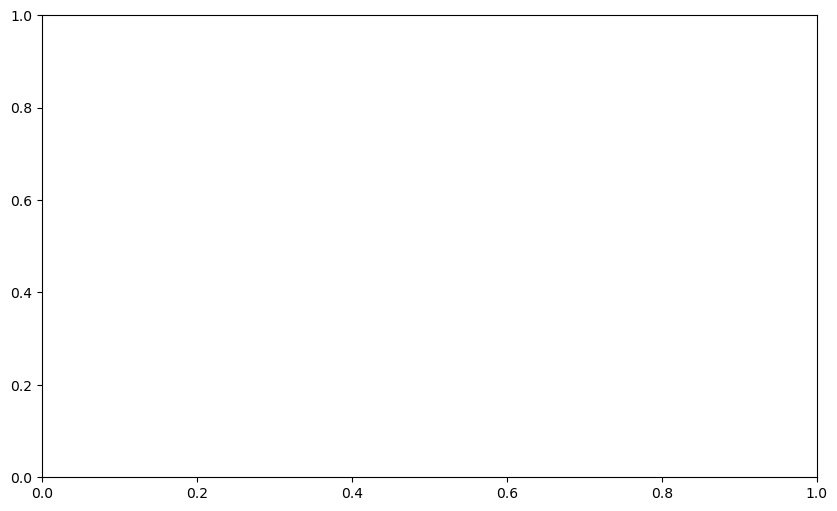

In [ ]:
# Plot

# Define categories for x-axis
categories = ["Any Quality", "Å < 3.5", "Å < 2.5", "Å < 1.5"]

x = np.arange(len(categories))
width = 0.25
color_in_pdb = "#FFB482" 
color_not_in_pdb = "#A1C9F4"

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Function to add percentage labels on top of bars
def add_labels(bars, df_in, df_not, column):
    for bar, category in zip(bars, categories):
        total = df_in[column][category] + df_not[column][category]
        if total > 0:
            percent = (df_in[column][category] / total) * 100
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f"{percent:.1f}%", ha='center', fontsize=10)

# Bars for Any CGC (All)
bars_all = ax.bar(x - width, df_in_pdb["All"], width, label="In PDB", color=color_in_pdb, lw=0.5, ec="black")
ax.bar(x - width, df_not_in_pdb["All"], width, bottom=df_in_pdb["All"], label="Not in PDB", color=color_not_in_pdb, lw=0.5, ec="black")
add_labels(bars_all, df_in_pdb, df_not_in_pdb, "All")

# Bars for CGC 1
bars_cgc = ax.bar(x, df_in_pdb["CGC"], width, color=color_in_pdb, lw=0.5, ec="black")
ax.bar(x, df_not_in_pdb["CGC"], width, bottom=df_in_pdb["CGC"], color=color_not_in_pdb, lw=0.5, ec="black")
add_labels(bars_cgc, df_in_pdb, df_not_in_pdb, "CGC")

# Bars for CGC 0
bars_not_cgc = ax.bar(x + width, df_in_pdb["Not CGC"], width, color=color_in_pdb, lw=0.5, ec="black")
ax.bar(x + width, df_not_in_pdb["Not CGC"], width, bottom=df_in_pdb["Not CGC"], color=color_not_in_pdb, lw=0.5, ec="black")
add_labels(bars_not_cgc, df_in_pdb, df_not_in_pdb, "Not CGC")

# Formatting
ax.set_xticks(np.concatenate([x - width, x, x + width]))
ax.set_xticklabels(["All"] * len(categories) + ["CGC"] * len(categories) + ["Not CGC"] * len(categories), 
                rotation=45, rotation_mode="anchor", ha='right', fontsize=11)

ax.set_ylabel("Number of genes", fontsize=12)
ax.set_title("Detected genes in solved PDB structures\n", fontsize=14)

# Add a secondary x-axis with quality labels
ax2 = ax.secondary_xaxis("top")
ax2.set_xticks(x)
ax2.set_xticklabels(categories, fontsize=11)

# Add legend
ax.legend(loc="upper right")

plt.show()


### Gene-cohort

In [58]:
genetable_all = pd.read_table(f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/o3d_paper/notebooks/0.genetables/results/{SUBDIR}/{RUN}.genetable.tsv")
genetable_all = genetable_all[["Gene", "CGC", "Fish", "o3d_qval", "Cohort"]]
genetable_all = genetable_all[genetable_all["o3d_qval"] < 0.01].reset_index(drop=True)
genetable_all = genetable_all.merge(canonical_metadata, on="Gene", how="left")
genetable_all

,Gene,CGC,Fish,o3d_qval,Cohort,Uniprot_ID
0,PIK3CA,1,0,0.0,HARTWIG_WGS_BLCA_2023,P42336
1,RXRA,0,0,0.0,HARTWIG_WGS_BLCA_2023,P19793
2,FGFR3,1,0,0.0,HARTWIG_WGS_BLCA_2023,P22607
3,FBXW7,1,0,0.0,HARTWIG_WGS_BLCA_2023,Q969H0
4,TP53,1,0,0.0,HARTWIG_WGS_BLCA_2023,P04637
...,...,...,...,...,...,...
614,MED12,1,0,0.0,TCGA_WXS_PRAD,Q93074
615,CTNNB1,1,0,0.0,TCGA_WXS_PRAD,P35222
616,TP53,1,0,0.0,TCGA_WXS_SOFT_TISSUE,P04637
617,HRAS,1,0,0.0,TCGA_WXS_PGNG,P01112


In [59]:
pdb_uniprot_all = genetable_all.merge(pdb_uniprot[["Uniprot_ID", "PDB", "Start", "End", "Resolution"]], on="Uniprot_ID", how="inner")
pdb_uniprot_all = pdb_uniprot_all[["Gene", "CGC", "Cohort", "Uniprot_ID"]].drop_duplicates()
pdb_uniprot_all

,Gene,CGC,Cohort,Uniprot_ID
0,PIK3CA,1,HARTWIG_WGS_BLCA_2023,P42336
110,PIK3CA,1,HARTWIG_WGS_UCEC_2023,P42336
220,PIK3CA,1,HARTWIG_WGS_COADREAD_2023,P42336
330,PIK3CA,1,CBIOP_WXS_BRCA_MBCP_PRY_NOTREAT_2020,P42336
440,PIK3CA,1,CBIOP_WXS_BRCA_MBCP_MET_TREAT_2020,P42336
...,...,...,...,...
39865,GTF2I,0,TCGA_WXS_THYM,P78347
39869,RHOA,1,TCGA_WXS_STAD,P61586
39959,CDH1,1,TCGA_WXS_STAD,P12830
39966,SPTA1,0,TCGA_WXS_STAD,P02549


In [60]:
print("> Oncodrive3D gene-cohort detected:", len(genetable_all))
display(genetable_all.value_counts("CGC"))
print("> Oncodrive3D gene-cohort detected with available PDB structure:", len(pdb_uniprot_all))
display(pdb_uniprot_all.value_counts("CGC"))

> Oncodrive3D gene-cohort detected: 619


CGC
1    429
0    190
dtype: int64

> Oncodrive3D gene-cohort detected with available PDB structure: 459


CGC
1    397
0     62
dtype: int64

## How many clusters in detected genes are in solved structures?

In [61]:
datasets = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

In [190]:
# Get all clusters in O3D detected genes

def get_o3d_clusters(genetable_df, o3d_output_dir):
    
    lst_cohort = []
    for cohort in genetable_df.Cohort.unique():
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        df_cohort = pd.read_csv(f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv")
        df_cohort = df_cohort[df_cohort["pval"] < 0.01]
        df_cohort = df_cohort[["Gene", "Uniprot_ID", "F", "Pos", "Score_obs_sim", "pLDDT_res", "Cohort"]]
        df_cohort = df_cohort.rename(columns={"Score_obs_sim" : "Clustering_score"})
        lst_cohort.append(df_cohort)

    df = pd.concat(lst_cohort).reset_index(drop=True)
    df = df.merge(genetable_df[["Gene", "CGC"]].drop_duplicates(), on=["Gene"], how="inner")
    df["CGC"] = df["CGC"].fillna(0)
    
    return df

o3d_clusters = get_o3d_clusters(genetable_all, o3d_output_dir)
o3d_clusters = o3d_clusters[["Gene", "Uniprot_ID", "Pos", "pLDDT_res", "CGC"]].drop_duplicates()
o3d_clusters = o3d_clusters.sort_values(["Gene", "Pos"]).reset_index(drop=True)
display(o3d_clusters.Gene.value_counts()[:10])
o3d_clusters

/tmp/jobs/spellegrini/10530889/ipykernel_1864055/3492789653.py:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cohort = pd.read_csv(f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv")


TP53      116
PTEN       46
IGLL5      36
PIK3CA     32
EGFR       31
VHL        27
CIC        23
FBXW7      22
SPOP       21
CHD4       21
Name: Gene, dtype: int64

,Gene,Uniprot_ID,Pos,pLDDT_res,CGC
0,ACVR1,D3DPA4,328,81.12,1
1,ADGRV1,Q8WXG9,4500,91.53,0
2,ADGRV1,Q8WXG9,4501,93.41,0
3,ADGRV1,Q8WXG9,4503,92.78,0
4,ADGRV1,Q8WXG9,4504,92.31,0
...,...,...,...,...,...
1373,ZNF83,P51522,290,96.00,0
1374,ZNF83,P51522,293,91.85,0
1375,ZNF880,Q6PDB4,406,89.35,0
1376,ZNF91,Q05481,353,81.18,0


In [216]:
# Report how many clusters have a solved structure

def get_cluster_in_pdb(o3d_clusters, pdb_uniprot):
    
    result = []
    for gene in o3d_clusters.Gene.unique():
        o3d_clusters_gene = o3d_clusters[o3d_clusters["Gene"] == gene]
        pdb_uniprot_gene = pdb_uniprot[pdb_uniprot["Gene"] == gene]
        o3d_clusters_gene = o3d_clusters_gene.copy()
        o3d_clusters_gene["In_PDB"] = o3d_clusters_gene["Pos"].apply(lambda pos: any((pos >= start and pos <= end) for start, end in zip(pdb_uniprot_gene["Start"], pdb_uniprot_gene["End"])))
        result.append(o3d_clusters_gene)
        
    o3d_clusters = pd.concat(result)
    o3d_clusters["In_PDB"] = o3d_clusters["In_PDB"].astype(int)
    
    return o3d_clusters


def report_cluster_in_pdb(o3d_clusters):

    cluster_in_pdb = o3d_clusters[o3d_clusters['In_PDB'] == 1]
    print(f"Total: {len(cluster_in_pdb)} on {len(o3d_clusters)} ({len(cluster_in_pdb) / len(o3d_clusters) * 100:.2f}%)")
    for cgc in [1, 0]:
        o3d_clusters_cgc = o3d_clusters[o3d_clusters["CGC"] == cgc]
        cluster_in_pdb = o3d_clusters_cgc[o3d_clusters_cgc['In_PDB'] == 1]
        print(f"CGC {cgc}: {len(cluster_in_pdb)} on {len(o3d_clusters_cgc)} ({len(cluster_in_pdb) / len(o3d_clusters_cgc) * 100:.2f}%)")
        

print("Clusters in solved structures:\n")
print("> Any quality:")
report_cluster_in_pdb(get_cluster_in_pdb(o3d_clusters, pdb_uniprot))

print("\n> Å < 3.5:")
report_cluster_in_pdb(get_cluster_in_pdb(o3d_clusters, pdb_uniprot[pdb_uniprot["Resolution"] < 3.5]))

print("\n> Å < 2.5:")
report_cluster_in_pdb(get_cluster_in_pdb(o3d_clusters, pdb_uniprot[pdb_uniprot["Resolution"] < 2.5]))

print("\n> Å < 1.5:")
report_cluster_in_pdb(get_cluster_in_pdb(o3d_clusters, pdb_uniprot[pdb_uniprot["Resolution"] < 1.5]))

Clusters in solved structures:

> Any quality:
Total: 748 on 1378 (54.28%)
CGC 1: 673 on 914 (73.63%)
CGC 0: 75 on 464 (16.16%)

> Å < 3.5:
Total: 706 on 1378 (51.23%)
CGC 1: 636 on 914 (69.58%)
CGC 0: 70 on 464 (15.09%)

> Å < 2.5:
Total: 609 on 1378 (44.19%)
CGC 1: 572 on 914 (62.58%)
CGC 0: 37 on 464 (7.97%)

> Å < 1.5:
Total: 241 on 1378 (17.49%)
CGC 1: 241 on 914 (26.37%)
CGC 0: 0 on 464 (0.00%)


In [320]:
# Define the total number of genes in each category
total_genes = 1378
cgc1_total = 914
cgc0_total = 464

# Define the detected genes at different PDB quality thresholds
in_pdb_genes = {
    "Any Quality": {"All": 748, "CGC": 673, "Not CGC": 75},
    "Å < 3.5": {"All": 706, "CGC": 636, "Not CGC": 70},
    "Å < 2.5": {"All": 609, "CGC": 572, "Not CGC": 37},
    "Å < 1.5": {"All": 241, "CGC": 241, "Not CGC": 0},
}

# Compute not detected genes
not_pdb_genes = {
    quality: {
        "All": total_genes - values["All"],
        "CGC": cgc1_total - values["CGC"],
        "Not CGC": cgc0_total - values["Not CGC"],
    }
    for quality, values in in_pdb_genes.items()
}

# Convert to DataFrame for easier handling
df_in_pdb = pd.DataFrame(in_pdb_genes).T
df_not_in_pdb = pd.DataFrame(not_pdb_genes).T

display(df_in_pdb)
display(df_not_in_pdb)

,All,CGC,Not CGC
Any Quality,748,673,75
Å < 3.5,706,636,70
Å < 2.5,609,572,37
Å < 1.5,241,241,0


,All,CGC,Not CGC
Any Quality,630,241,389
Å < 3.5,672,278,394
Å < 2.5,769,342,427
Å < 1.5,1137,673,464


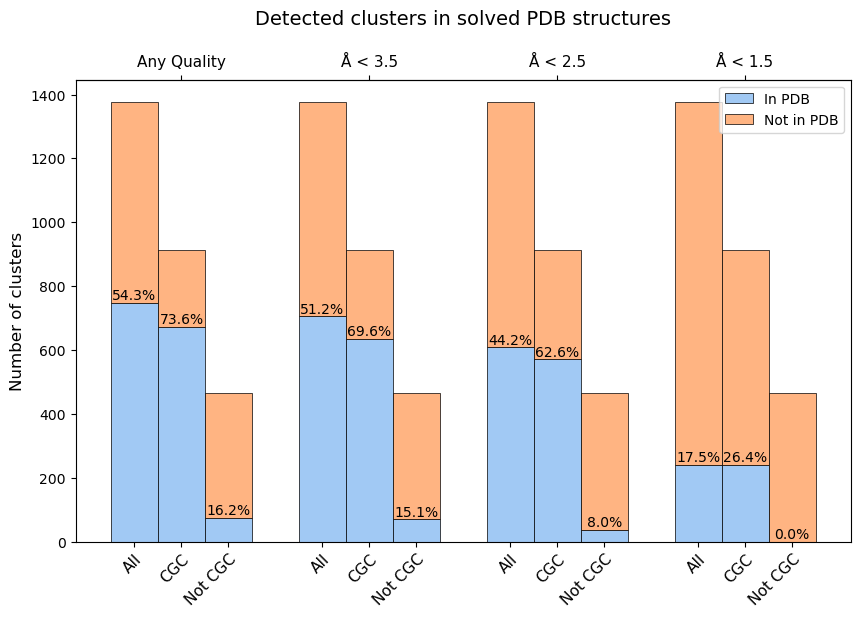

In [322]:
# Plot

# Define categories for x-axis
categories = ["Any Quality", "Å < 3.5", "Å < 2.5", "Å < 1.5"]

x = np.arange(len(categories))
width = 0.25
color_in_pdb = "#FFB482" 
color_not_in_pdb = "#A1C9F4"

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Function to add percentage labels on top of bars
def add_labels(bars, df_in, df_not, column):
    for bar, category in zip(bars, categories):
        total = df_in[column][category] + df_not[column][category]
        if total > 0:
            percent = (df_in[column][category] / total) * 100
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 9, f"{percent:.1f}%", ha='center', fontsize=10)

# Bars for Any CGC (All)
bars_all = ax.bar(x - width, df_in_pdb["All"], width, label="In PDB", color=color_in_pdb, lw=0.5, ec="black")
ax.bar(x - width, df_not_in_pdb["All"], width, bottom=df_in_pdb["All"], label="Not in PDB", color=color_not_in_pdb, lw=0.5, ec="black")
add_labels(bars_all, df_in_pdb, df_not_in_pdb, "All")

# Bars for CGC 1
bars_cgc = ax.bar(x, df_in_pdb["CGC"], width, color=color_in_pdb, lw=0.5, ec="black")
ax.bar(x, df_not_in_pdb["CGC"], width, bottom=df_in_pdb["CGC"], color=color_not_in_pdb, lw=0.5, ec="black")
add_labels(bars_cgc, df_in_pdb, df_not_in_pdb, "CGC")

# Bars for CGC 0
bars_not_cgc = ax.bar(x + width, df_in_pdb["Not CGC"], width, color=color_in_pdb, lw=0.5, ec="black")
ax.bar(x + width, df_not_in_pdb["Not CGC"], width, bottom=df_in_pdb["Not CGC"], color=color_not_in_pdb, lw=0.5, ec="black")
add_labels(bars_not_cgc, df_in_pdb, df_not_in_pdb, "Not CGC")

# Formatting
ax.set_xticks(np.concatenate([x - width, x, x + width]))
ax.set_xticklabels(["All"] * len(categories) + ["CGC"] * len(categories) + ["Not CGC"] * len(categories), 
                rotation=45, rotation_mode="anchor", ha='right', fontsize=11)

ax.set_ylabel("Number of clusters", fontsize=12)
ax.set_title("Detected clusters in solved PDB structures\n", fontsize=14)

# Add a secondary x-axis with quality labels
ax2 = ax.secondary_xaxis("top")
ax2.set_xticks(x)
ax2.set_xticklabels(categories, fontsize=11)

# Add legend
ax.legend(loc="upper right")

plt.show()

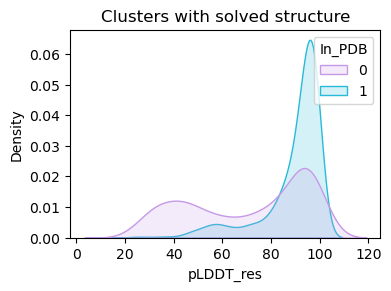

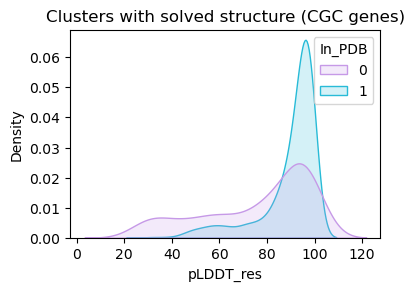

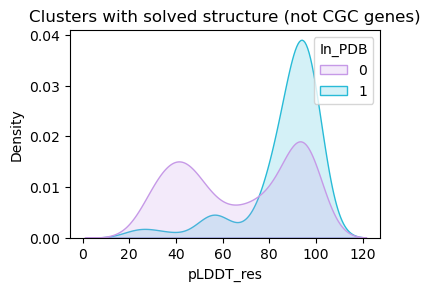

In [214]:
o3d_clusters_in_pdb = get_cluster_in_pdb(o3d_clusters, pdb_uniprot)

fig, ax = plt.subplots(figsize=(4, 2.7))    
lut = {1: '#28BBD7', 0: '#C699E7'}
sns.kdeplot(data=o3d_clusters_in_pdb, x='pLDDT_res', hue='In_PDB', fill=True, common_norm=False, palette=lut, alpha=0.2, legend=True)
plt.title("Clusters with solved structure")
plt.show()

fig, ax = plt.subplots(figsize=(4, 2.7))    
lut = {1: '#28BBD7', 0: '#C699E7'}
plt.title("Clusters with solved structure (CGC genes)")
sns.kdeplot(data=o3d_clusters_in_pdb[o3d_clusters_in_pdb["CGC"] == 1], x='pLDDT_res', hue='In_PDB', fill=True, common_norm=False, palette=lut, alpha=0.2, legend=True)
plt.show()

fig, ax = plt.subplots(figsize=(4, 2.7))    
lut = {1: '#28BBD7', 0: '#C699E7'}
plt.title("Clusters with solved structure (not CGC genes)")
sns.kdeplot(data=o3d_clusters_in_pdb[o3d_clusters_in_pdb["CGC"] == 0], x='pLDDT_res', hue='In_PDB', fill=True, common_norm=False, palette=lut, alpha=0.2, legend=True)
plt.show()